# GRU Model

## Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from keras.models import Sequential
from sklearn.preprocessing import normalize, StandardScaler
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)


## Data Preparation

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

In [4]:
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.fit_transform(X_test)

sequence_length = 10
batch_size = 32

train_sequences = []
test_sequences = []

for i in range(len(train_features) - sequence_length + 1):
    train_sequences.append(train_features[i:i + sequence_length])
xtrain = np.array(train_sequences)
ytrain = y_train[sequence_length - 1:]


for i in range(len(test_features) - sequence_length + 1):
    test_sequences.append(test_features[i:i + sequence_length])
xtest = np.array(test_sequences)
ytest = y_test[sequence_length - 1:]

## Helper Functions

In [5]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building
### Base Model

In [6]:
def create_gru_model(sequence_length, num_features):
    model = Sequential()
    model.add(GRU(32, input_shape=(sequence_length, num_features), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

In [7]:
# Create and compile the model
sequence_length, num_features = sequence_length, X_train.shape[1]
model = create_gru_model(sequence_length, num_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,065
Trainable params: 4,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=100, validation_data=(xtest, ytest))

Epoch 1/100
280/280 [==============================] - 3s 5ms/step - loss: 0.6507 - accuracy: 0.6329 - precision: 0.5387 - recall: 0.1207 - val_loss: 0.6301 - val_accuracy: 0.6717 - val_precision: 0.6500 - val_recall: 0.1639
Epoch 2/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6452 - precision: 0.6250 - recall: 0.1255 - val_loss: 0.6283 - val_accuracy: 0.6726 - val_precision: 0.6422 - val_recall: 0.1765
Epoch 3/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.6477 - precision: 0.6289 - recall: 0.1392 - val_loss: 0.6282 - val_accuracy: 0.6753 - val_precision: 0.6700 - val_recall: 0.1690
Epoch 4/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6465 - precision: 0.6257 - recall: 0.1339 - val_loss: 0.6257 - val_accuracy: 0.6682 - val_precision: 0.6585 - val_recall: 0.1362
Epoch 5/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6439

280/280 [==============================] - 1s 5ms/step - loss: 0.6269 - accuracy: 0.6559 - precision: 0.6401 - recall: 0.1802 - val_loss: 0.6263 - val_accuracy: 0.6686 - val_precision: 0.5886 - val_recall: 0.2219
Epoch 38/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6251 - accuracy: 0.6550 - precision: 0.6217 - recall: 0.1954 - val_loss: 0.6243 - val_accuracy: 0.6673 - val_precision: 0.6202 - val_recall: 0.1627
Epoch 39/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy: 0.6532 - precision: 0.6263 - recall: 0.1778 - val_loss: 0.6248 - val_accuracy: 0.6619 - val_precision: 0.5766 - val_recall: 0.1803
Epoch 40/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6577 - precision: 0.6420 - recall: 0.1891 - val_loss: 0.6246 - val_accuracy: 0.6619 - val_precision: 0.5812 - val_recall: 0.1715
Epoch 41/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6239 - accuracy: 0.6552 - preci

280/280 [==============================] - 1s 4ms/step - loss: 0.6165 - accuracy: 0.6563 - precision: 0.6021 - recall: 0.2360 - val_loss: 0.6293 - val_accuracy: 0.6686 - val_precision: 0.5923 - val_recall: 0.2144
Epoch 74/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6164 - accuracy: 0.6591 - precision: 0.6184 - recall: 0.2286 - val_loss: 0.6327 - val_accuracy: 0.6664 - val_precision: 0.5690 - val_recall: 0.2497
Epoch 75/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6182 - accuracy: 0.6571 - precision: 0.6119 - recall: 0.2247 - val_loss: 0.6304 - val_accuracy: 0.6682 - val_precision: 0.5798 - val_recall: 0.2383
Epoch 76/100
280/280 [==============================] - 1s 5ms/step - loss: 0.6147 - accuracy: 0.6626 - precision: 0.6298 - recall: 0.2348 - val_loss: 0.6336 - val_accuracy: 0.6588 - val_precision: 0.5444 - val_recall: 0.2396
Epoch 77/100
280/280 [==============================] - 1s 4ms/step - loss: 0.6146 - accuracy: 0.6605 - preci

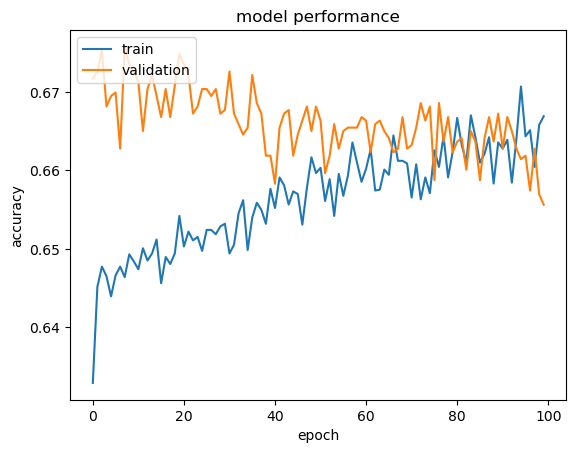

In [9]:
plot_hist(history)

In [10]:
y_pred = model.predict(xtest)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(ytest, y_pred)
print("Accuracy: ", accuracy_score(ytest, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(ytest, y_pred))

70/70 [==============================] - 0s 1ms/step
Accuracy:  0.6556202418271384

Confusion Matrix: 
 [[1287  153]
 [ 616  177]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      1440
         1.0       0.54      0.22      0.32       793

    accuracy                           0.66      2233
   macro avg       0.61      0.56      0.54      2233
weighted avg       0.63      0.66      0.61      2233



### Tuned Model

In [17]:
def build_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int("units", min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(sequence_length, X_train.shape[1]),
    ))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "sgd"]),
        loss=hp.Choice("loss", ["binary_crossentropy", "mean_squared_error"]),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [18]:
# RandomSearch to find the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials as needed
    directory='tuned_models',
    project_name='thyroid_gru_tuning'
)

tuner.search(xtrain, 
             ytrain, 
             validation_data=(xtest, ytest),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

INFO:tensorflow:Reloading Tuner from tuned_models\thyroid_gru_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [24]:
# get params of best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)
best_hps

In [28]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 160)           81600     
                                                                 
 dropout (Dropout)           (None, 10, 160)           0         
                                                                 
 dense (Dense)               (None, 10, 1)             161       
                                                                 
Total params: 81,761
Trainable params: 81,761
Non-trainable params: 0
_________________________________________________________________


In [39]:
# build and fit best model
best_model.build(xtrain.shape)
history = best_model.fit(xtrain, ytrain, batch_size=batch_size, epochs=100, validation_data=(xtest, ytest))

Epoch 1/100


TypeError: 'NoneType' object is not callable

In [ ]:
plot_hist(history)

In [ ]:
y_pred = model.predict(xtest)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(ytest, y_pred)
print("Accuracy: ", accuracy_score(ytest, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(ytest, y_pred))